# Trabajo Práctico ACN
## Simulación Molino de Viento

La empresa tiene dos molinos de viento en Patagonia, a cierta distancia entre sí. Llamamos a uno molino Norte y al otro molino Sur. Para el viento promedio (espacial) de la región en cada día \(i\) considerará que el siguiente modelo representa bien la realidad:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

con $\Delta = 1/365$ y la media estacional

$$
\theta(t_i) = 6 + 2 \cos\left(\frac{2\pi i}{365}\right)
$$

El reloj \(t_i\) corre en frecuencia diaria y el shock \(Z\) es una variable normal estándar (media = 0, std dev = 1) e independiente entre días consecutivos.

La diferencia de viento entre el molino Norte y el molino Sur es cero el primer día y luego evoluciona como

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

donde los shocks \(W\) son shocks normalmente distribuidos e independientes de los shocks \(Z\) que impulsan al viento regional.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Cargamos los datos del viento

In [8]:
viento = pd.read_excel('WindData.xlsx')
viento

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442
...,...,...,...
3645,3646,8.642231,-0.869425
3646,3647,6.527408,-1.268447
3647,3648,6.230707,-1.149234
3648,3649,5.550882,-0.420431


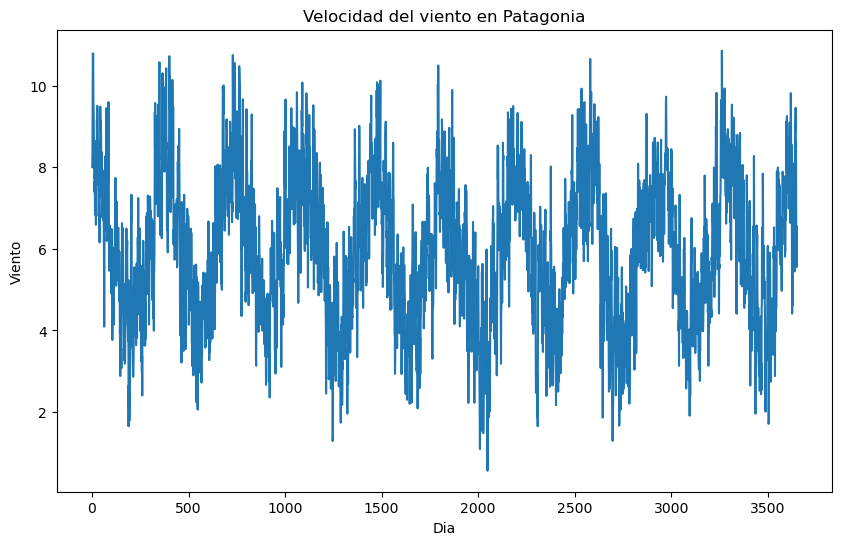

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(viento['dia'], viento['regional wind'])
plt.xlabel('Dia')
plt.ylabel('Viento')
plt.title('Velocidad del viento en Patagonia')
plt.show()

In [9]:
delta = 1/365
#Si+1 - Si = k(theta - si)delta + sigma*raiz(delta)*shock
# Si+1 - Si = Yi
# (theta-si)delta = Xi
# sigma*raiz(delta) = c

#Regresion lineal
## Yi = k*Xi + c*Zi --> Zi ~ N(0, c**2)

theta = 6 + 2 * np.cos(2 * np.pi * np.array(range(3649)) / 365)

#Ecuacion 1
Y = (viento["regional wind"][1:]-viento["regional wind"].shift(1)[1:]).values
X = ((theta - viento["regional wind"][:-1])*delta).values

regresion = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = regresion.predict(X.reshape(-1,1))
error = Y-Y_pred
c = error.var()
S_0 = viento["regional wind"].iloc[0]
kappa = regresion.coef_[0]
# theta = viento["regional wind"].mean()
sigma = np.sqrt(c/delta)


In [40]:
# Ecuacion 2
#D_i+1 - D_i = - beta * D_i *  Delta + gamma * sqrt{Delta} * W_i
#D_i+1 - D_i = Y
# -D_i* delta = X
# gamma*sqrt(delta) = c

#Regresion lineal
## Yi = beta*Xi + c*Zi --> Zi ~ N(0, c**2)

Y = (viento["wind gap norte sur"][1:] - viento["wind gap norte sur"].shift(1)[1:]).values
X = (-viento["wind gap norte sur"][:-1] * delta).values

regresion = LinearRegression().fit(X.reshape(-1, 1), Y)
Y_pred = regresion.predict(X.reshape(-1, 1))
error = Y - Y_pred
c = error.var()
beta = regresion.coef_[0] 
gamma = np.sqrt(c / delta)

# Resultados
print("Estimación de beta:", beta)
print("Estimación de gamma:", gamma)


Estimación de beta: 48.37733323194376
Estimación de gamma: 10.09071995713833


In [29]:
# Gráfico de residuos
# plt.figure(figsize=(10, 5))
# plt.plot(error, label='Residuos')
# plt.axhline(error.mean(), color='red', linestyle='--', label='Cero')
# plt.xlabel('Días')
# plt.ylabel('Error')
# plt.title('Residuos de la regresión para estimar beta y gamma')
# plt.legend()
# plt.show()


In [44]:
def regional_wind_paths(S_0, k, theta, sigma, delta, T, m):   
    #Si+1 - Si = k(theta - si)delta + sigma*raiz(delta)*shock
    S = np.zeros((m,T+1))
    S[:,0] = S_0
    for i in range(m):
        for t in range(1,T+1):
            S[i,t] = S[i, t-1]+k*(theta[t-1]-S[i,t-1])*delta + sigma*np.sqrt(delta)*np.random.normal(0,1)
    return S

def gap_wind_paths(D_0, beta, gamma, delta, T, m):
    D = np.zeros((m, T+1))
    D[:,0] = D_0
    for i in range(m):
        for t in range(1, T+1):
            D[i, t] = D[i, t-1] - beta*D[i, t-1]*delta + gamma*np.sqrt(delta)*np.random.normal(0, 1)
    return D

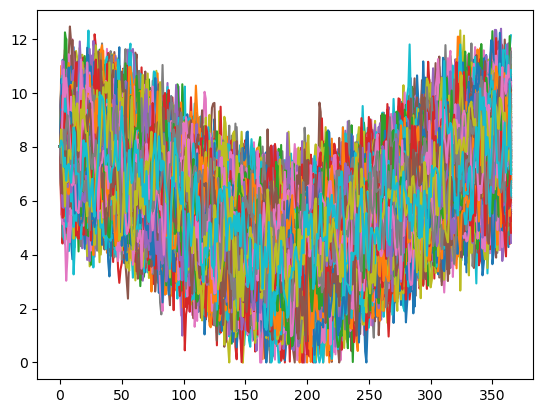

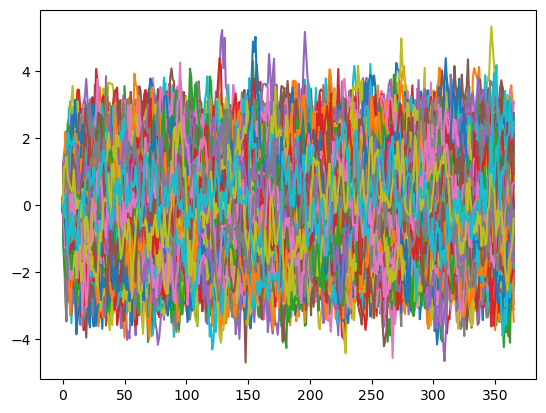

In [45]:
#simulacion 1 año viento regional
S_0 = viento["regional wind"].iloc[0]
D_0 = viento["wind gap norte sur"].iloc[0]
num_sim = 1000
T = 365
S = regional_wind_paths(S_0, kappa, theta, sigma,delta, T, num_sim)
D = gap_wind_paths(D_0, beta, gamma, delta, T, num_sim)

for s_i in S:
    plt.plot(s_i)
plt.show()

for d_i in D:
    plt.plot(d_i)
plt.show()



In [46]:
viento_molino_norte = S+D
viento_molino_sur = S-D

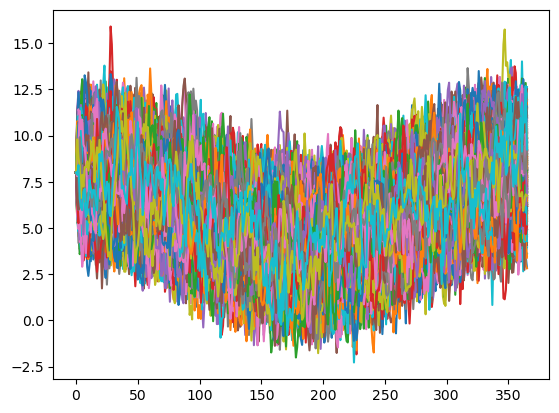

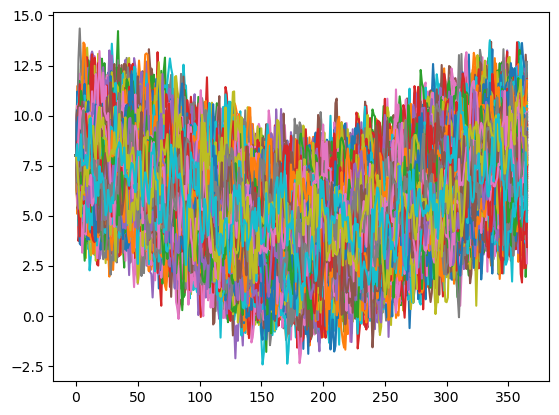

In [47]:
for vn_i in viento_molino_norte:
    plt.plot(vn_i)
plt.show()
for vs_i in viento_molino_sur:
    plt.plot(vs_i)
plt.show()